# Classification with Dirichlet prior

In [1]:
%load_ext autoreload
%autoreload 2
import site
import time
site.addsitedir('..')

import jax
from jax.config import config
import jax.numpy as jnp
import numpy as np
from  matplotlib import pyplot as plt
from tqdm import tqdm

from jax.scipy.special import gammaln
from jax import random

from src.algorithm import mcmc

plt.rcParams["figure.figsize"]=6,6
#config.update("jax_enable_x64", True)

### Setup

The probability vector $\pi$ is drawn from a Dirichlet distribution with parameter $\alpha$.

$\pi \sim \text{Dirichlet}(\alpha)$

The $K$ classes $x_1, \ldots, x_K$ are i.i.d. samples from a standard normal distribution and we have $N$ noisy observations $y_1, \ldots, y_N$ of the $K$ classes such that:

$y_i = x_{z_i} + \sigma \eta_i,$

where $\eta_i \sim \mathcal{N}(0,1)$ and $z_1, \ldots, z_N$ are drawn from a multinomial distribution with
probability vector $\pi$.

In [740]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, *subkeys = random.split(key, 5)

In [747]:
K = 10
N = 1000
sigma = 0.03
alpha = 0.7 * jnp.ones(K,)
#alpha = jnp.array([10,10,2])

In [748]:
pi = random.dirichlet(subkeys[0], alpha)
z = random.categorical(subkeys[1], jnp.log(pi), shape = (N,))
print(f"pi = {pi}")

pi = [0.01207974 0.22626306 0.04141581 0.08789956 0.03968062 0.01636302
 0.00174355 0.32687056 0.06601959 0.18166453]


x = [-0.04346443 -0.4092391   1.6317272   1.1915433   0.51219404 -0.7797925
  0.46418872 -2.2547438   0.3551698   1.2771338 ]


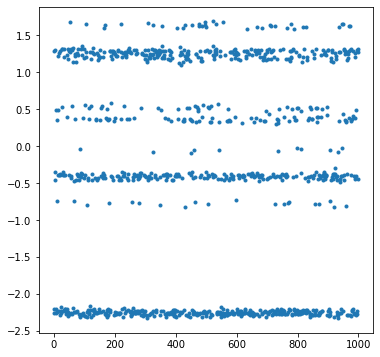

In [749]:
x = random.normal(subkeys[2], shape = (K,))
y = x[z] + sigma * random.normal(subkeys[3], shape = (N,))

print(f"x = {x}")
_ = plt.plot(y, '.')

### The posterior and proposal functions

In [772]:
# This log posterior marginalizes over the classes k = 1,...,K.
def logPi_marg(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) *  (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
        
        logPZalpha += gammaln(n_k[k] + alpha[k])
      
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) 
   
# And this does not.
def logPi(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    n_ik_z = jax.vmap(lambda i : n_ik[i, z[i]])(jnp.arange(N))
    
    term1 = jnp.sum(-(y - x[z])**2/sigma)
    term2 = jnp.sum(jnp.log(n_ik_z + alpha[z])) 

    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))

    return term1 + term2 - jnp.sum(x**2) #+ logPZalpha 


def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [773]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

5062.7725
4777.269


In [774]:
@jax.jit
def proposal_x_marg(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_k] from the posterior
    
    p(x_1, ..., x_K | y_1, ..., y_N)
    
    with marginalization over z_1,...z_N."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi_marg(x0, z, y, sigma, alpha)
    logPiX1 = logPi_marg(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_K] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    without marginalization over z_i variales (where we keep z_i fixed)."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x_idx(key, x0, logPiX0, B, z, y, sigma, alpha, idx):
    """Proposal function for a new state x_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)
    
    where all z_i and the other x_j are fixed and with no
    marginalization over z.

    The returned vector x1 is equal to x0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.uniform(key) * 2*B-B
    x1 = x0.at[idx].set(newval)
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x1, r, logPiX1, logPiX0    
               

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Proposal function of a new vector [z_1,...,z_N] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where the x_i variables are fixed."""
    
    z1 = random.randint(key, z0.shape, 0, K) 

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_idx(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    """Proposal function of a new state z_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where all x_i and the other z_j are fixed.
    
    The returned vector z1 is equal to z0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.randint(key, (), 0, K) 
    z1 = z0.at[idx].set(newval)
    
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

### Sample x

In [752]:
print(f"pi = {pi}")
print(f"x = {x}")

pi = [0.01207974 0.22626306 0.04141581 0.08789956 0.03968062 0.01636302
 0.00174355 0.32687056 0.06601959 0.18166453]
x = [-0.04346443 -0.4092391   1.6317272   1.1915433   0.51219404 -0.7797925
  0.46418872 -2.2547438   0.3551698   1.2771338 ]


In [697]:
#z_rand = random.categorical(subkey, jnp.log(pi), shape = (N,))
#z_rand = random.randint(subkey, (N,), 0, K)

#### Sampling the marginalized posterior

  MCMC sample 1000, loss = 1659.691650390625, a = 0.0
  MCMC sample 2000, loss = 1433.853515625, a = 0.0
  MCMC sample 3000, loss = 1262.4512939453125, a = 0.0
  MCMC sample 4000, loss = 1262.4512939453125, a = 0.0
  MCMC sample 5000, loss = 1262.4512939453125, a = 0.0
  MCMC sample 6000, loss = 1262.4512939453125, a = 0.0
  MCMC sample 7000, loss = 1262.4512939453125, a = 0.0
  MCMC sample 8000, loss = 1262.4512939453125, a = 0.0
  MCMC sample 9000, loss = 1262.4512939453125, a = 0.0
18.835962772369385 sec
x_samp = [ 0.97928023  2.055068   -0.39224195]
x_true = [-0.42080927  1.9656439   0.928362  ]


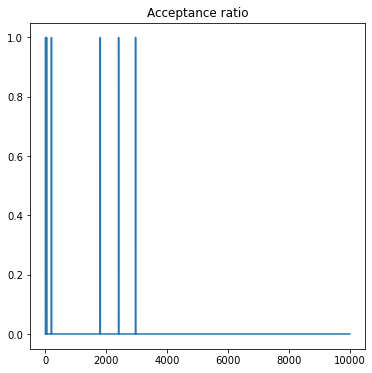

In [10]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### And the non-marginalized posterior

  MCMC sample 1000, loss = 3832.76171875, a = 0.0
  MCMC sample 2000, loss = 3832.76171875, a = 0.0
  MCMC sample 3000, loss = 4530.708984375, a = 0.0
  MCMC sample 4000, loss = 4530.708984375, a = 0.0
  MCMC sample 5000, loss = 4530.708984375, a = 0.0
  MCMC sample 6000, loss = 4530.708984375, a = 0.0
  MCMC sample 7000, loss = 4530.708984375, a = 0.0
  MCMC sample 8000, loss = 4530.708984375, a = 0.0
  MCMC sample 9000, loss = 4530.708984375, a = 0.0
16.108863830566406 sec
x_samp = [-0.31087732  1.8224821   0.87926316]
x_true = [-0.42080927  1.9656439   0.928362  ]


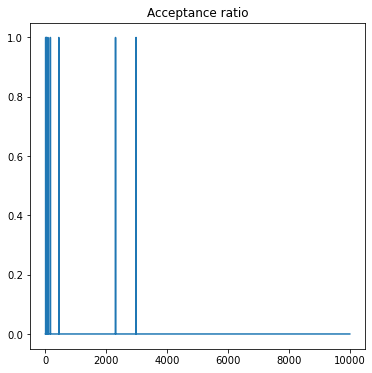

In [11]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### One $x_i$ at a time

  MCMC sample 1000, loss = 654.5516357421875, a = 0.0
  MCMC sample 2000, loss = 653.760498046875, a = 0.0
  MCMC sample 3000, loss = 654.7591552734375, a = 0.0
  MCMC sample 4000, loss = 654.7420654296875, a = 0.0
  MCMC sample 5000, loss = 654.678955078125, a = 0.0
  MCMC sample 6000, loss = 652.0994873046875, a = 0.0
  MCMC sample 7000, loss = 654.67333984375, a = 0.0
  MCMC sample 8000, loss = 653.2642822265625, a = 0.0
  MCMC sample 9000, loss = 654.7830810546875, a = 0.0
  MCMC sample 10000, loss = 652.9879150390625, a = 0.0
16.228681087493896 sec
x_samp = [-0.40595675  1.3225673   0.90517974]
x_true = [-0.42080927  1.9656439   0.928362  ]


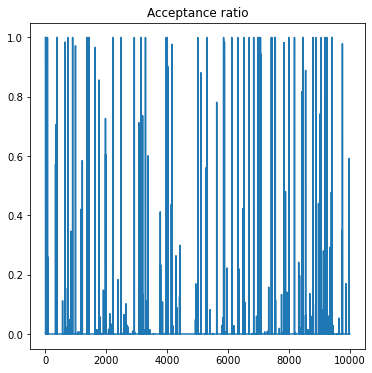

In [12]:
N_samples_x = 10001
B = 3

idx = 2
x0 = jnp.array(np.random.randn(K))

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

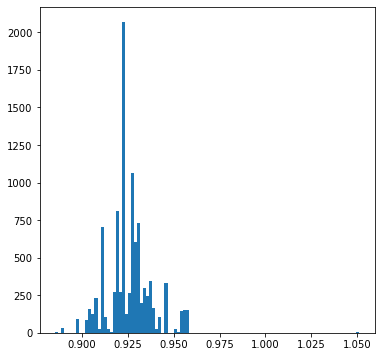

In [13]:
nbins=100
counts, bins = np.histogram(x_samples[:,idx], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

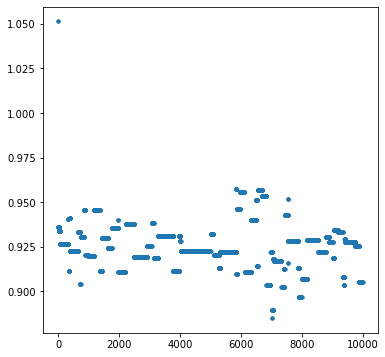

In [14]:
plt.plot(x_samples[:,idx],'.')

### Sample z

  MCMC sample 1000, loss = 3257.5888671875, a = 0.011484041810035706
4.277724981307983 sec
z[idx]_samp = 0
z[idx]_true = 2


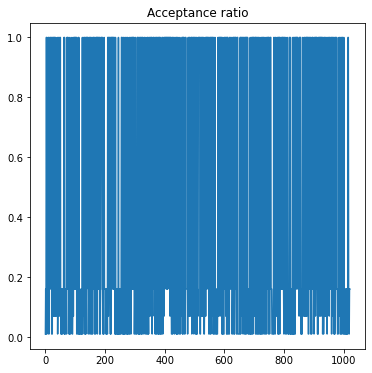

In [385]:
N_samples_z = 1023
z0 = jnp.array(np.random.randint(0, K, (N,)))
#z0 = z.at[idx].set(np.random.randint(0,K,())

B = 2
idx = 10
params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx}

key, subkey = random.split(key)

t0 = time.time()
z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, z0, N_samples_z, params_z, 1, 1)

z_samples = z_samples[:,idx]

print(f"{time.time()-t0} sec")
plt.plot(z_r); plt.title("Acceptance ratio")
print(f"z[idx]_samp = {z_samples[N_samples_z-2]}")
print(f"z[idx]_true = {z[idx]}")


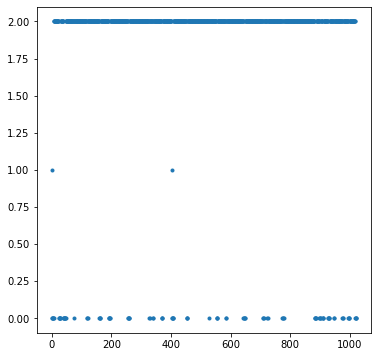

In [95]:
plt.plot(z_samples, '.')

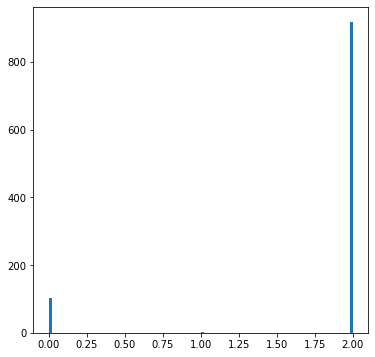

In [96]:
nbins=100
counts, bins = np.histogram(z_samples, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

### Sample $x$ and $z$

In [775]:
N_iters = 10
N_samples_z = 50 #300
N_samples_x = 3001
B = 3

sample_x = True
sample_z = False
search_z = True

zi = jnp.array(np.random.randint(0, K, (N,)))
xi = jnp.array(np.random.randn(K))

#xi = x
#zi = z

t0 = time.time()
for iter_i in jnp.arange(N_iters):
    print(f"Iter = {iter_i}")

    if sample_x:
        print("  Sampling x")
        for idx_x in jnp.arange(K):

            params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx_x}
            #params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha}

            key, subkey = random.split(key)
    
            #t0 = time.time()
            x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, xi, N_samples_x, params_x, 1, 1) 
            #x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, xi, N_samples_x, params_x, 1, 1) 

            xi = x_samples[N_samples_x - 2]
    
    if search_z:
        print("  Searching z")
        for idx_z in tqdm(jnp.arange(N)):
            logPi_max = -jnp.inf

            for ki in jnp.arange(K):
                zi_k = zi.at[idx_z].set(ki)
                logPi_k = logPi(xi, zi_k, y, sigma, alpha)
                if logPi_k > logPi_max:
                    zi = zi_k
                    logPi_max = logPi_k
            
    if sample_z:
        print("  Sampling z")
        for idx_z in tqdm(jnp.arange(N)):
            
            params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx_z}

            key, subkey = random.split(key)

            z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, zi, N_samples_z, params_z, 1, 1)

            #zi = z_samples[N_samples_z - 2]
            
            new_zi = jnp.bincount(z_samples[:,idx_z]).argmax()
            zi = zi.at[idx_z].set(new_zi)
            
            #if zi[idx_z] - z[idx_z] != 0:
            #    break
            

print(f"{time.time()-t0} sec")
print(f"x_samp = {xi}")
print(f"x_true = {x}")

Iter = 0
  Sampling x
  MCMC sample 1000, loss = -111524.484375, a = 0.0
  MCMC sample 2000, loss = -111524.046875, a = 0.0
  MCMC sample 3000, loss = -111524.203125, a = 0.0
  MCMC sample 1000, loss = -111327.703125, a = 0.0
  MCMC sample 2000, loss = -111327.734375, a = 0.0
  MCMC sample 3000, loss = -111327.8515625, a = 0.0
  MCMC sample 1000, loss = -110059.453125, a = 0.0
  MCMC sample 2000, loss = -110059.6796875, a = 0.0
  MCMC sample 3000, loss = -110060.8828125, a = 0.0
  MCMC sample 1000, loss = -106992.4140625, a = 0.0
  MCMC sample 2000, loss = -106991.8515625, a = 0.0
  MCMC sample 3000, loss = -106991.9609375, a = 0.0
  MCMC sample 1000, loss = -87674.1875, a = 0.0
  MCMC sample 2000, loss = -87674.09375, a = 0.0
  MCMC sample 3000, loss = -87673.9765625, a = 0.0
  MCMC sample 1000, loss = -86461.9765625, a = 0.0
  MCMC sample 2000, loss = -86462.390625, a = 0.0
  MCMC sample 3000, loss = -86461.7734375, a = 0.0
  MCMC sample 1000, loss = -81551.640625, a = 0.0
  MCMC sam

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.67it/s]


Iter = 1
  Sampling x
  MCMC sample 1000, loss = -51003.07421875, a = 0.03290724381804466
  MCMC sample 2000, loss = -51003.73828125, a = 0.001203337567858398
  MCMC sample 3000, loss = -51004.87109375, a = 0.13428209722042084
  MCMC sample 1000, loss = -51004.76171875, a = 0.2865048050880432
  MCMC sample 2000, loss = -51004.9765625, a = 0.011328102089464664
  MCMC sample 3000, loss = -51005.05859375, a = 0.7460454702377319
  MCMC sample 1000, loss = -51005.015625, a = 0.026338625699281693
  MCMC sample 2000, loss = -51005.27734375, a = 0.012637410312891006
  MCMC sample 3000, loss = -51004.98828125, a = 0.056858617812395096
  MCMC sample 1000, loss = -51000.9453125, a = 0.0
  MCMC sample 2000, loss = -51001.2265625, a = 0.0
  MCMC sample 3000, loss = -51000.796875, a = 0.0
  MCMC sample 1000, loss = -23011.5859375, a = 0.0
  MCMC sample 2000, loss = -23011.49609375, a = 0.0
  MCMC sample 3000, loss = -23011.876953125, a = 0.0
  MCMC sample 1000, loss = -3411.25146484375, a = 0.0
  MC

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.81it/s]


Iter = 2
  Sampling x
  MCMC sample 1000, loss = 2656.99951171875, a = 0.08699587732553482
  MCMC sample 2000, loss = 2657.737548828125, a = 0.022933730855584145
  MCMC sample 3000, loss = 2657.6455078125, a = 0.44439780712127686
  MCMC sample 1000, loss = 2657.47021484375, a = 0.6353284120559692
  MCMC sample 2000, loss = 2657.939697265625, a = 0.13800452649593353
  MCMC sample 3000, loss = 2657.666748046875, a = 0.8464128375053406
  MCMC sample 1000, loss = 2677.798828125, a = 0.0
  MCMC sample 2000, loss = 2677.8701171875, a = 0.0
  MCMC sample 3000, loss = 2677.849365234375, a = 0.0
  MCMC sample 1000, loss = 2679.646240234375, a = 0.0
  MCMC sample 2000, loss = 2679.43212890625, a = 0.0
  MCMC sample 3000, loss = 2679.815185546875, a = 0.0
  MCMC sample 1000, loss = 2974.0234375, a = 0.0
  MCMC sample 2000, loss = 2974.022216796875, a = 7.26964827000498e-29
  MCMC sample 3000, loss = 2973.267578125, a = 0.0
  MCMC sample 1000, loss = 4535.59912109375, a = 0.0
  MCMC sample 2000, l

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 14.93it/s]


Iter = 3
  Sampling x
  MCMC sample 1000, loss = 5141.88818359375, a = 0.0011337477480992675
  MCMC sample 2000, loss = 5141.72705078125, a = 0.14448633790016174
  MCMC sample 3000, loss = 5141.2109375, a = 0.0010983295505866408
  MCMC sample 1000, loss = 5141.45947265625, a = 1.0
  MCMC sample 2000, loss = 5141.4365234375, a = 0.060555242002010345
  MCMC sample 3000, loss = 5141.466796875, a = 1.0
  MCMC sample 1000, loss = 5142.01611328125, a = 0.0
  MCMC sample 2000, loss = 5144.65087890625, a = 0.0
  MCMC sample 3000, loss = 5144.85986328125, a = 0.0
  MCMC sample 1000, loss = 5144.84716796875, a = 0.0
  MCMC sample 2000, loss = 5145.0576171875, a = 0.0
  MCMC sample 3000, loss = 5145.013671875, a = 0.0
  MCMC sample 1000, loss = 5145.021484375, a = 0.0
  MCMC sample 2000, loss = 5145.78955078125, a = 0.0
  MCMC sample 3000, loss = 5145.787109375, a = 0.0
  MCMC sample 1000, loss = 5215.85400390625, a = 0.0
  MCMC sample 2000, loss = 5215.8564453125, a = 0.0
  MCMC sample 3000, los

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.87it/s]


Iter = 4
  Sampling x
  MCMC sample 1000, loss = 5217.71875, a = 1.0
  MCMC sample 2000, loss = 5217.77099609375, a = 0.00040981502388603985
  MCMC sample 3000, loss = 5217.47265625, a = 0.015430847182869911
  MCMC sample 1000, loss = 5217.453125, a = 0.08180491626262665
  MCMC sample 2000, loss = 5217.1044921875, a = 0.00043988204561173916
  MCMC sample 3000, loss = 5217.41552734375, a = 1.0
  MCMC sample 1000, loss = 5217.1640625, a = 0.0
  MCMC sample 2000, loss = 5216.451171875, a = 0.0
  MCMC sample 3000, loss = 5217.35888671875, a = 0.0
  MCMC sample 1000, loss = 5217.08251953125, a = 2.5673341177752384e-36
  MCMC sample 2000, loss = 5216.94384765625, a = 0.0
  MCMC sample 3000, loss = 5217.341796875, a = 0.0
  MCMC sample 1000, loss = 5217.181640625, a = 0.0
  MCMC sample 2000, loss = 5216.9765625, a = 0.0
  MCMC sample 3000, loss = 5216.486328125, a = 0.0
  MCMC sample 1000, loss = 5216.43115234375, a = 0.0
  MCMC sample 2000, loss = 5216.43115234375, a = 0.0
  MCMC sample 3000

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.84it/s]


Iter = 5
  Sampling x
  MCMC sample 1000, loss = 5213.60009765625, a = 1.0
  MCMC sample 2000, loss = 5212.845703125, a = 0.01532572228461504
  MCMC sample 3000, loss = 5214.0869140625, a = 1.0
  MCMC sample 1000, loss = 5213.48291015625, a = 0.7607598900794983
  MCMC sample 2000, loss = 5213.54150390625, a = 0.4284178614616394
  MCMC sample 3000, loss = 5213.666015625, a = 0.014781845733523369
  MCMC sample 1000, loss = 5211.279296875, a = 0.16040104627609253
  MCMC sample 2000, loss = 5212.77978515625, a = 0.0
  MCMC sample 3000, loss = 5213.64306640625, a = 0.0
  MCMC sample 1000, loss = 5213.6982421875, a = 0.0
  MCMC sample 2000, loss = 5213.64697265625, a = 0.0
  MCMC sample 3000, loss = 5213.548828125, a = 1.3400549505604431e-05
  MCMC sample 1000, loss = 5214.34765625, a = 0.0
  MCMC sample 2000, loss = 5214.2900390625, a = 0.0
  MCMC sample 3000, loss = 5214.36181640625, a = 0.0
  MCMC sample 1000, loss = 5214.43017578125, a = 0.0
  MCMC sample 2000, loss = 5214.07080078125, a

  3%|███████▊                                                                                                                                                                                                                                                                               | 28/1000 [00:01<01:08, 14.12it/s]


KeyboardInterrupt: 

In [754]:
print(x[z[idx_z]])
print(xi[zi[idx_z]])

1.2771338
1.2677736


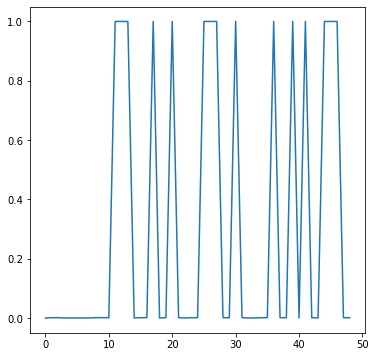

In [701]:
plt.plot(z_r)

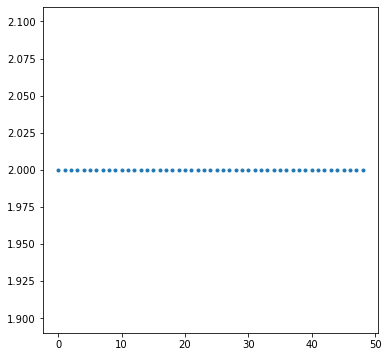

In [702]:
plt.plot(z_samples[:,idx_z], '.')

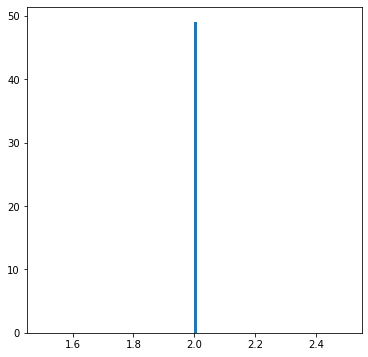

In [703]:
nbins=100
counts, bins = np.histogram(z_samples[:,idx_z], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [704]:
zi[idx_z]

DeviceArray(2, dtype=int32)

In [705]:
z_samples[1,idx_z]

DeviceArray(2, dtype=int32)

In [706]:
z_r[1]

DeviceArray(0.00094636, dtype=float32)

In [707]:
zi[2]

DeviceArray(2, dtype=int32)

In [708]:
z_samples.shape

(49, 1000)

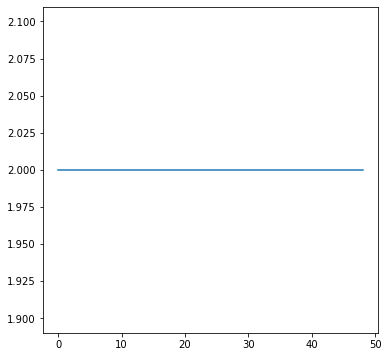

In [709]:
plt.plot(z_samples[:,18])

0
0
118
240
340
302
0
0
0
0
0


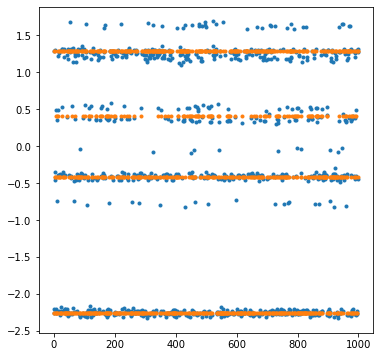

In [777]:
plt.plot(y, '.')
plt.plot(xi[zi], '.')

print(jnp.sum(zi==0))
print(jnp.sum(zi==1))
print(jnp.sum(zi==2))
print(jnp.sum(zi==3))
print(jnp.sum(zi==4))
print(jnp.sum(zi==5))
print(jnp.sum(zi==6))
print(jnp.sum(zi==7))
print(jnp.sum(zi==8))
print(jnp.sum(zi==9))
print(jnp.sum(zi==10))

In [778]:
zi[18]

DeviceArray(4, dtype=int32)

In [779]:
y[18]

DeviceArray(-2.2328756, dtype=float32)

In [780]:
logPiZ0 = logPi(xi, zi, y, sigma, alpha)
logPiZ1 = logPi(xi, zi.at[18].set(2), y, sigma, alpha)

jnp.exp(logPiZ1-logPiZ0)

DeviceArray(0., dtype=float32)

In [781]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

5062.7725
5213.593


In [782]:
z1 = z.at[0].set(1)
logPiZ0 = logPi(x, z, y, sigma, alpha)
logPiZ1 = logPi(x, z1, y, sigma, alpha)
r = jnp.exp(logPiZ1 - logPiZ0)
r

DeviceArray(0., dtype=float32)

11
209
37
87
41
20
2
340
75
178
0


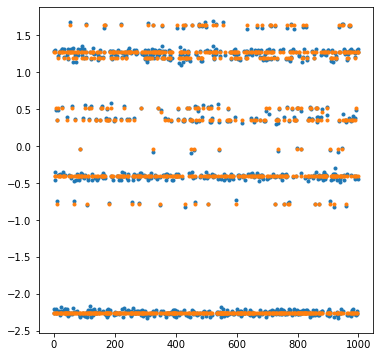

In [784]:
plt.plot(y, '.')
plt.plot(x[z], '.')

print(jnp.sum(z==0))
print(jnp.sum(z==1))
print(jnp.sum(z==2))
print(jnp.sum(z==3))
print(jnp.sum(z==4))
print(jnp.sum(z==5))
print(jnp.sum(z==6))
print(jnp.sum(z==7))
print(jnp.sum(z==8))
print(jnp.sum(z==9))
print(jnp.sum(z==10))

In [786]:
pi

DeviceArray([0.01207974, 0.22626306, 0.04141581, 0.08789956, 0.03968062,
             0.01636302, 0.00174355, 0.32687056, 0.06601959, 0.18166453],            dtype=float32)

In [377]:
print(pi)
print(x)
print(xi)

[0.58926904 0.30704442 0.1036865 ]
[-1.2071892  -0.88907737 -1.4734226 ]
[-1.14765   -1.0816076 -0.9918773]


In [378]:
# Loss functions roughly equivalent with the the estimation problem to see what's going on
def loss_fun(x, z, y):
    return (x[z] - y)**2 * pi[z]

def loss_fun_vmap(x,z,y):
    n_k = calc_nk_jit(z)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))
    print(f"logPZalpha = {-logPZalpha}")
    return jnp.sum(jax.vmap(loss_fun, in_axes = (None, 0, 0))(x,z,y)) + jnp.sum(x**2) - logPZalpha

In [379]:
n_k = calc_nk_jit(z)
logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))

In [380]:
jnp.sum(gammaln(n_k+alpha))

DeviceArray(5108.597, dtype=float32)

In [381]:
gammaln(jnp.sum(n_k) + jnp.sum(alpha))

DeviceArray(6057.421, dtype=float32)

In [382]:
alpha.shape

(3,)

In [383]:
print(loss_fun_vmap(x, jnp.array(np.random.randint(0, K, (N,))), y))
print(loss_fun_vmap(xi, zi, y))
print(loss_fun_vmap(x, z, y))

logPZalpha = 1125.63525390625
1152.383
logPZalpha = 70.2763671875
94.29922
logPZalpha = 948.82373046875
953.63257


In [88]:
alpha

DeviceArray([10, 10,  2], dtype=int32)

### Some functions used for debugging - ignore

In [236]:
# Quick test of a proposal function
key, subkey = random.split(key)
idx = 1
z1, rz, _, _ = proposal_z_idx(subkey, z, -1, x, y, sigma, alpha, K, idx)
print(z1[idx])
print(rz)

1
1.0


In [ ]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

In [ ]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   

print(probs_d)
#print(jnp.sum(probs_d, axis=1))

plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [ ]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [ ]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

In [ ]:
plt.imshow((myf_xy)); plt.colorbar()

In [ ]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

In [ ]:
myf(x[0],x[1])

In [ ]:
jnp.max(myf_xy)